In [1]:
from model import Network
from data import load_cifar10_dataloaders, WhiteningTransformation
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from criterion import ReconstructImageFromFCLoss
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
# load to model
model_config = './model_config/fc1_cocktail_party_cifar10_instance.json'
checkpoint_path = './checkpoints/122123_fc1_cocktail_party_cifar10_pretraining_wout_bias_wout_normalization.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Network(model_config)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)

# get val loader
batch_size = 4
data_path = './data'
transform = transforms.Compose([
    transforms.ToTensor(),
])

_, val_dataloader = load_cifar10_dataloaders(data_path, batch_size, transform)
selected_val_batch_data, selected_val_batch_label = next(iter(val_dataloader))
selected_val_batch_data = selected_val_batch_data.to(device)
selected_val_batch_label = selected_val_batch_label.to(device)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# receiving gradients
model.zero_grad()
criterion = nn.CrossEntropyLoss()
output = model(selected_val_batch_data.reshape(batch_size, -1))
loss = criterion(output, selected_val_batch_label)
loss.backward()
gradient_of_layers = []
for param in model.parameters():
    gradient_of_layers.append(param.grad.data.clone().to('cpu'))
print([x.size() for x in gradient_of_layers])

[torch.Size([10, 3072])]


In [4]:
whitening_transform = WhiteningTransformation()
whitened_gradient = torch.from_numpy(whitening_transform.transform(gradient_of_layers[0].detach().numpy().T)).to(torch.float32).T
whitened_gradient = whitened_gradient.to(device)

In [5]:
# criterion output testing
unmixing_matrix = torch.rand((selected_val_batch_data.size(0), gradient_of_layers[0].size(0)), requires_grad=True, device=device)
reconstruction_loss = ReconstructImageFromFCLoss(32, 32, 3, 1, 1, 1)
optimizer = torch.optim.Adam([unmixing_matrix])

for iter_idx in range(25000):
    optimizer.zero_grad()
    # out_score, non_gaussianity_score, total_variance_score, mutual_independence_score
    loss, _, _, _ = reconstruction_loss(unmixing_matrix, whitened_gradient)
    loss.backward()
    optimizer.step()
    
    if (iter_idx + 1) % 1000 == 0 or iter_idx == 0:
        print('loss: {}'.format(loss.item()))

loss: 2.5163211822509766
loss: 1.0536198616027832
loss: 1.045462965965271
loss: 1.037050724029541
loss: 1.0307040214538574
loss: 1.0263868570327759
loss: 1.023785948753357
loss: 1.0216796398162842
loss: 1.0195311307907104
loss: 1.0183677673339844
loss: 1.0170326232910156
loss: 1.01596200466156
loss: 1.0147167444229126
loss: 1.0140089988708496
loss: 1.0132551193237305
loss: 1.0122277736663818
loss: 1.0120923519134521
loss: 1.0110753774642944
loss: 1.0110838413238525
loss: 1.0099906921386719
loss: 1.0094245672225952
loss: 1.0089186429977417
loss: 1.0093717575073242
loss: 1.0083138942718506
loss: 1.0081405639648438
loss: 1.0077110528945923


## Estimated images

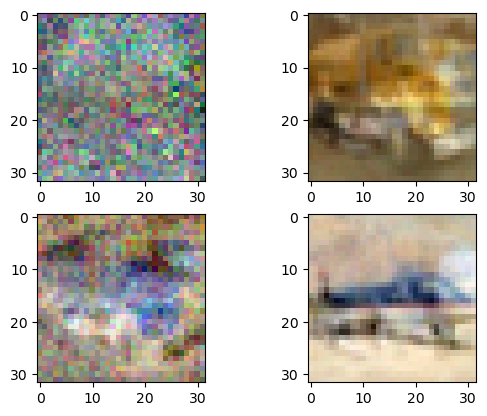

In [6]:
with torch.no_grad():
    unmixing_matrix = unmixing_matrix.detach().to('cpu')
    whitened_gradient = whitened_gradient.detach().to('cpu')
    estimated_img = unmixing_matrix @ whitened_gradient
    
    fig, axes = plt.subplots(2, 2)
    
    for estimate, ax in zip(estimated_img, axes.flatten()):
        img = colors.Normalize()(np.asarray(-estimate)).reshape(3, 32, 32).transpose(1, 2, 0)
        ax.imshow(img)
    plt.show()

## Original images

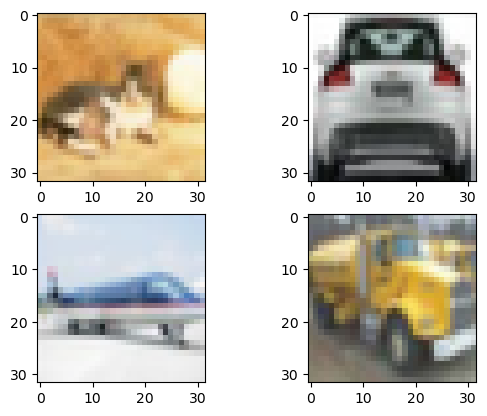

In [7]:
with torch.no_grad():
    fig, axes = plt.subplots(2, 2)
    
    for estimate, ax in zip(selected_val_batch_data, axes.flatten()):
        img = transforms.ToPILImage()(estimate.reshape(3, 32, 32))
        img = np.asarray(img)
        ax.imshow(img)
    plt.show()

In [17]:
from metrics import psnr
with torch.no_grad():
    tmp = torch.stack([torch.from_numpy(colors.Normalize()(np.asarray(-estimate)).reshape(3, 32, 32)) for estimate in estimated_img], 0)
    psnr_val = psnr(tmp, selected_val_batch_data.detach().to('cpu').reshape(selected_val_batch_data.shape[0], 3, 32, 32))

In [18]:
psnr_val

9.325193

In [32]:
def psnr_matching(img_batch, ref_batch):
    pairwise_psnr = torch.zeros((img_batch.shape[0], ref_batch.shape[0]))
    for row_idx, img_in in enumerate(img_batch):
        for col_idx, img_ref in enumerate(ref_batch):
            score = psnr(img_in, img_ref)
            pairwise_psnr[row_idx, col_idx] = score.item()

    mask = torch.zeros((img_batch.shape[0], ref_batch.shape[0])).to(bool)
    match = []
    for best_idx in range(img_batch.shape[0]):
        pairwise_psnr[mask] = -torch.inf
        torch.argmax(pairwise_psnr)
        selected_match = (pairwise_psnr == torch.max(pairwise_psnr)).nonzero()[0]
        match.append(selected_match)
        mask[selected_match[0], :] = True
        mask[:, selected_match[1]] = True

    return match

with torch.no_grad():
    tmp = torch.stack([torch.from_numpy(colors.Normalize()(np.asarray(-estimate)).reshape(3, 32, 32)) for estimate in estimated_img], 0)
    matches = psnr_matching(tmp, selected_val_batch_data.detach().to('cpu').reshape(selected_val_batch_data.shape[0], 3, 32, 32))

In [35]:
matches = torch.stack(matches, 0)

In [38]:
matches

tensor([[1, 3],
        [3, 2],
        [2, 0],
        [0, 1]])

In [36]:
with torch.no_grad():
    tmp = torch.stack([torch.from_numpy(colors.Normalize()(np.asarray(-estimate)).reshape(3, 32, 32)) for estimate in estimated_img], 0)
    psnr_val = psnr(tmp[matches[:, 0]], selected_val_batch_data[matches[:, 1]].detach().to('cpu').reshape(selected_val_batch_data.shape[0], 3, 32, 32))

In [22]:
psnr_val

14.330371

In [37]:
psnr_val

13.15881

In [18]:
batch_size = 8
_, val_dataloader = load_cifar10_dataloaders(data_path, batch_size, transform)
selected_val_batch_data, selected_val_batch_label = next(iter(val_dataloader))
selected_val_batch_data = selected_val_batch_data.to(device)
selected_val_batch_label = selected_val_batch_label.to(device)

# receiving gradients
model.zero_grad()
criterion = nn.CrossEntropyLoss()
output = model(selected_val_batch_data.reshape(batch_size, -1))
loss = criterion(output, selected_val_batch_label)
loss.backward()
gradient_of_layers = []
for param in model.parameters():
    gradient_of_layers.append(param.grad.data.clone().to('cpu'))
print([x.size() for x in gradient_of_layers])

whitening_transform = WhiteningTransformation()
whitened_gradient = torch.from_numpy(whitening_transform.transform(gradient_of_layers[0].detach().numpy().T)).to(torch.float32).T
whitened_gradient = whitened_gradient.to(device)

# criterion output testing
unmixing_matrix = torch.rand((selected_val_batch_data.size(0), gradient_of_layers[0].size(0)), requires_grad=True, device=device)
reconstruction_loss = ReconstructImageFromFCLoss(32, 32, 3, 1, 1, 1)
optimizer = torch.optim.Adam([unmixing_matrix])

for iter_idx in range(25000):
    optimizer.zero_grad()
    # out_score, non_gaussianity_score, total_variance_score, mutual_independence_score
    loss, _, _, _ = reconstruction_loss(unmixing_matrix, whitened_gradient)
    loss.backward()
    optimizer.step()
    
    if (iter_idx + 1) % 1000 == 0 or iter_idx == 0:
        print('loss: {}'.format(loss.item()))

Files already downloaded and verified
Files already downloaded and verified
[torch.Size([10, 3072])]
loss: 2.28903865814209
loss: 1.0427366495132446
loss: 1.0374895334243774
loss: 1.032583236694336
loss: 1.028232216835022
loss: 1.0245743989944458
loss: 1.021378517150879
loss: 1.018816351890564
loss: 1.0166983604431152
loss: 1.0148147344589233
loss: 1.013060450553894
loss: 1.0116437673568726
loss: 1.0106165409088135
loss: 1.0094677209854126
loss: 1.008799433708191
loss: 1.0078388452529907
loss: 1.0075416564941406
loss: 1.0071312189102173
loss: 1.0064181089401245
loss: 1.0066235065460205
loss: 1.0059937238693237
loss: 1.0066425800323486
loss: 1.0056257247924805
loss: 1.0057408809661865
loss: 1.0061872005462646
loss: 1.005713701248169


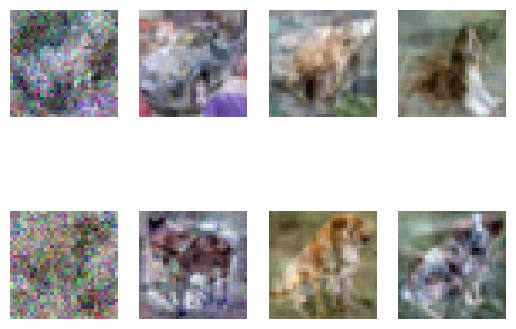

In [19]:
with torch.no_grad():
    unmixing_matrix = unmixing_matrix.detach().to('cpu')
    whitened_gradient = whitened_gradient.detach().to('cpu')
    estimated_img = unmixing_matrix @ whitened_gradient
    
    fig, axes = plt.subplots(2, 4)
    
    for estimate, ax in zip(estimated_img, axes.flatten()):
        img = colors.Normalize()(np.asarray(-estimate)).reshape(3, 32, 32).transpose(1, 2, 0)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

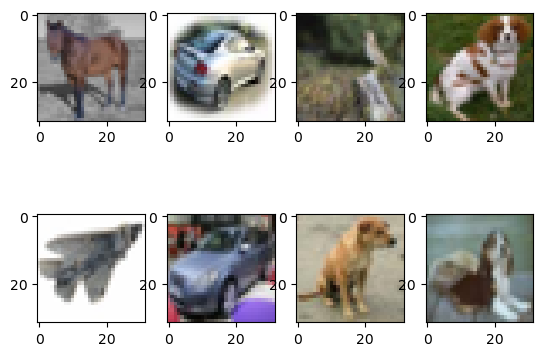

In [20]:
with torch.no_grad():
    fig, axes = plt.subplots(2, 4)
    
    for estimate, ax in zip(selected_val_batch_data, axes.flatten()):
        img = transforms.ToPILImage()(estimate.reshape(3, 32, 32))
        img = np.asarray(img)
        ax.imshow(img)
    plt.show()

In [21]:
batch_size = 16
_, val_dataloader = load_cifar10_dataloaders(data_path, batch_size, transform)
selected_val_batch_data, selected_val_batch_label = next(iter(val_dataloader))
selected_val_batch_data = selected_val_batch_data.to(device)
selected_val_batch_label = selected_val_batch_label.to(device)

# receiving gradients
model.zero_grad()
criterion = nn.CrossEntropyLoss()
output = model(selected_val_batch_data.reshape(batch_size, -1))
loss = criterion(output, selected_val_batch_label)
loss.backward()
gradient_of_layers = []
for param in model.parameters():
    gradient_of_layers.append(param.grad.data.clone().to('cpu'))
print([x.size() for x in gradient_of_layers])

whitening_transform = WhiteningTransformation()
whitened_gradient = torch.from_numpy(whitening_transform.transform(gradient_of_layers[0].detach().numpy().T)).to(torch.float32).T
whitened_gradient = whitened_gradient.to(device)

# criterion output testing
unmixing_matrix = torch.rand((selected_val_batch_data.size(0), gradient_of_layers[0].size(0)), requires_grad=True, device=device)
reconstruction_loss = ReconstructImageFromFCLoss(32, 32, 3, 1, 1, 1)
optimizer = torch.optim.Adam([unmixing_matrix])

for iter_idx in range(25000):
    optimizer.zero_grad()
    # out_score, non_gaussianity_score, total_variance_score, mutual_independence_score
    loss, _, _, _ = reconstruction_loss(unmixing_matrix, whitened_gradient)
    loss.backward()
    optimizer.step()
    
    if (iter_idx + 1) % 1000 == 0 or iter_idx == 0:
        print('loss: {}'.format(loss.item()))

Files already downloaded and verified
Files already downloaded and verified
[torch.Size([10, 3072])]
loss: 2.2155604362487793
loss: 1.191004753112793
loss: 1.12984037399292
loss: 1.1135075092315674
loss: 1.1081223487854004
loss: 1.1041314601898193
loss: 1.1010245084762573
loss: 1.0987507104873657
loss: 1.097028374671936
loss: 1.0957282781600952
loss: 1.0948525667190552
loss: 1.094148874282837
loss: 1.0935096740722656
loss: 1.0930395126342773
loss: 1.093061923980713
loss: 1.0927506685256958
loss: 1.0925095081329346
loss: 1.0925908088684082
loss: 1.092570185661316
loss: 1.09223210811615
loss: 1.0923748016357422
loss: 1.0922194719314575
loss: 1.0925849676132202
loss: 1.0927932262420654
loss: 1.091961145401001
loss: 1.0929592847824097


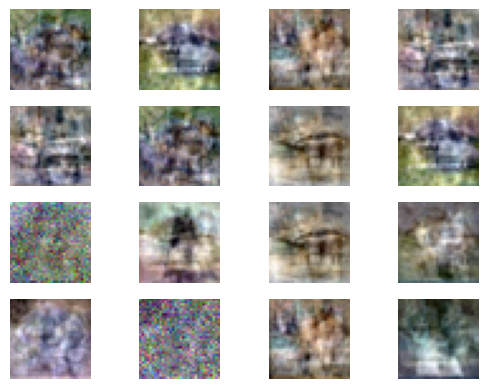

In [22]:
with torch.no_grad():
    unmixing_matrix = unmixing_matrix.detach().to('cpu')
    whitened_gradient = whitened_gradient.detach().to('cpu')
    estimated_img = unmixing_matrix @ whitened_gradient
    
    fig, axes = plt.subplots(4, 4)
    
    for estimate, ax in zip(estimated_img, axes.flatten()):
        img = colors.Normalize()(np.asarray(-estimate)).reshape(3, 32, 32).transpose(1, 2, 0)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

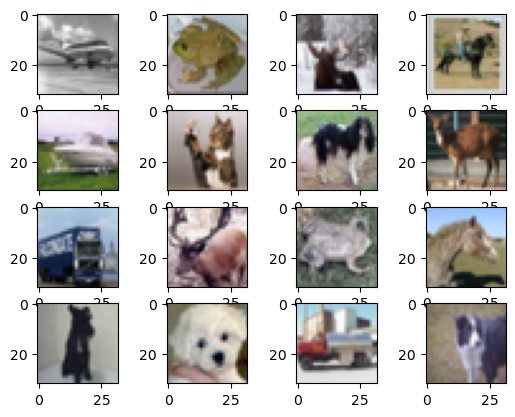

In [23]:
with torch.no_grad():
    fig, axes = plt.subplots(4, 4)
    
    for estimate, ax in zip(selected_val_batch_data, axes.flatten()):
        img = transforms.ToPILImage()(estimate.reshape(3, 32, 32))
        img = np.asarray(img)
        ax.imshow(img)
    plt.show()